# **Indonesia Case Study 🇮🇩**

Our research examines Indonesia’s long-term economic development by focusing on the roles of capital accumulation, saving, population growth, and research and development. Institutional and cultural factors, though potentially important, are not considered in this analysis to maintain a clear focus on these key economic drivers.

This notebook serves as the coding part of the project, aiming to answer key questions related to Indonesia's economic development using provided data. It includes:

1. **Trend Calculation**: Analyses the trends for the natural logarithms of real GDP and real GDP per capita at constant 2017 national prices, with robustness checks using levels instead of log levels.

2. **Total Factor Productivity (TFP) Measure**: Derives TFP using a production function, considering real GDP, the number of employed workers, and the capital stock, while testing robustness with alternative values for the production parameter alpha.

3. **Growth Accounting**: Breaks down the contributions of input variables to changes in GDP, focusing on long-run developments rather than yearly averages.

4. **Labour Productivity**: Constructs a series for GDP per worker to study labour productivity trends.




## **1. Import Modules ⚙️** 
Load essential libraries and custom functions for data analysis and visualisation.

In [1]:
# Import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

import openpyxl

## **2. Data Loading and Cleaning 📈** 
We load and clean the data for our analysis in the later section.

In [2]:
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [3]:
# Clean data

# Subset relevant columns and compute per capita real GDP
data = data.loc[:, ("country", "year", "rgdpna", "pop")]
data["rgdpna_pc"] = data["rgdpna"] / data["pop"]

# Select Indonesia as country of focus
data_indonesia = data.loc[data["country"] == "Indonesia", ("year", "rgdpna", "rgdpna_pc")]
# Reset the index
data_indonesia = data_indonesia.reset_index(drop = True)

# Subset the RGDP and RGDP per capita series
ymax = 2019
ymin = 1960
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y_gdp = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, data_indonesia["year"] >= ymin), "rgdpna"]
Y_pc = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, data_indonesia["year"] >= ymin), "rgdpna_pc"]
y_gdp = np.log(Y_gdp)
y_pc = np.log(Y_pc)
data_indonesia = data_indonesia[data_indonesia["year"] >= ymin] 

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T_gdp = len(Y_gdp) # sample size used for regression
T_pc = len(Y_pc)
T_all = data_indonesia["year"].max() - (ymin - 1)

# Check values
print(T_gdp)
print(T_pc)
print(T_all)

60
60
60


## **3. Project Tasks Overview**

- **3.1   Trend Calculation**:  Analyse trends for real GDP and GDP per capita (logarithms and levels) using constant 2017 national prices.

- **3.2  TFP Measure**:         Extract Total Factor Productivity using real GDP, employment, capital stock, and optionally the human capital index.

- **3.3  Growth Accounting**:   Decompose GDP growth contributions, focusing on long-term trends.

- **3.4  Labour Productivity**: Create a time series for GDP per worker.

### **3.1.1 Trend Calculation**

We analyse GDP trends using four different models to understand their fit and performance:

**(a) Additive + Linear**

**(b) Additive + Quadratic**

**(c) Exponential + Linear**

**(d) Exponential + Quadratic**


### **(a) Linear Additive**

   A simple linear trend fitted to the natural logarithm of GDP.

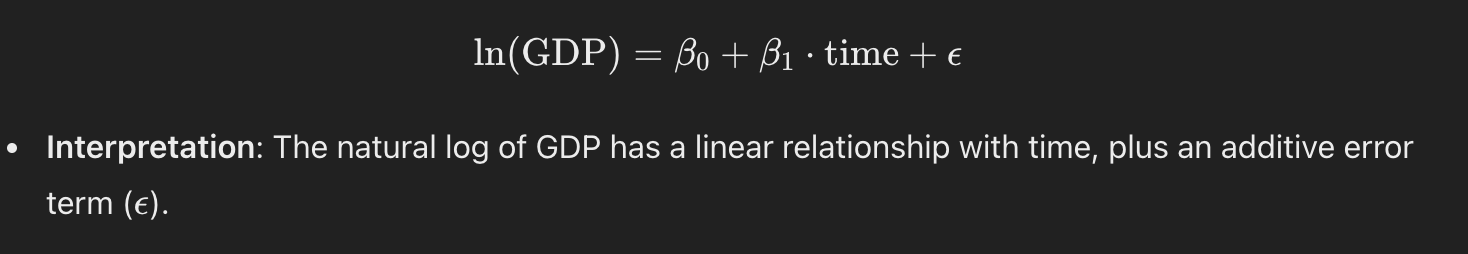



In [4]:
# Suppress runtime warnings for invalid values in log
np.seterr(invalid='ignore') 

# Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is RGDP and RGDP per capita in *levels*

def additive_linear_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T)  # initialise an empty vector for the first regressor
    x2 = np.empty(T)  # initialise an empty vector for the second regressor

    for t in range(T):
        x1[t] = 1.
        x2[t] = t + 1  # recall that Python starts indexing at 0
        
    a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)
    
    # Initialise predicted values yhat
    Yhat_add_lin = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1)  # recall that Python indexing starts at 0
        
    # Convert into log-units (suppress warnings for invalid values)
    yhat_add_lin = np.log(Yhat_add_lin)

    return Yhat_add_lin, yhat_add_lin

# Apply the function to both RGDP and RGDP per capita
Yhat_add_lin_gdp, yhat_add_lin_gdp = additive_linear_model(Y_gdp, T_all)
Yhat_add_lin_pc, yhat_add_lin_pc = additive_linear_model(Y_pc, T_all)


### **(b) Additive Quadratic**

A quadratic trend fitted to the natural logarithm of GDP to account for non-linear growth patterns.

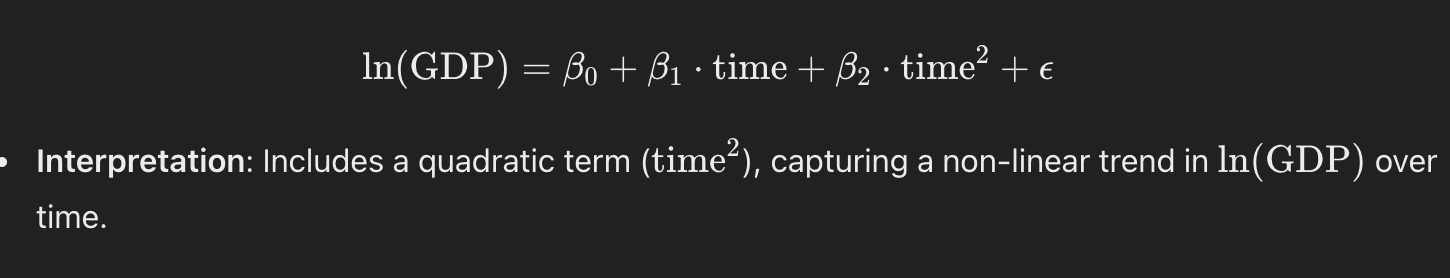

In [5]:
# Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *levels*

def additive_quadratic_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 
    x3 = np.empty(T)

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        x3[t] = (t + 1) ** 2

    a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)
    
    # Initialise predicted values yhat
    Yhat_add_quad = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1) ** 2
        
    # Take the natural logarithm of the shifted fitted values
    yhat_add_quad = np.log(Yhat_add_quad)
    
    return Yhat_add_quad, yhat_add_quad

# Apply the function to both RGDP and RGDP per capita
Yhat_add_quad_gdp, yhat_add_quad_gdp = additive_quadratic_model(Y_gdp, T_all)
Yhat_add_quad_pc, yhat_add_quad_pc = additive_quadratic_model(Y_pc, T_all)

### **(c) Exponential Linear**

An exponential trend fitted to GDP data to capture compounding growth over time.

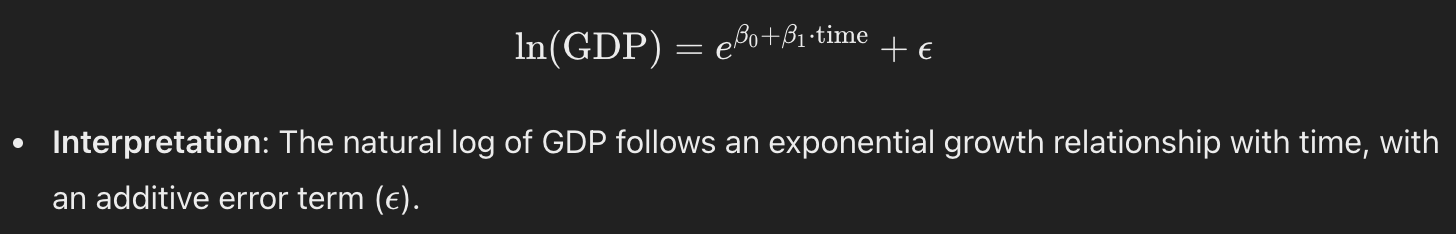

In [6]:
# Exponential Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *ln*

def exponential_linear_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        
    y_exp_lin = np.log(Y)
    
    a_exp_lin, b_exp_lin = get_regression_coefs(y_exp_lin, x1, x2)
    
    # Initialise predicted values yhat
    yhat_exp_lin = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)

    return yhat_exp_lin

# Apply the function to both RGDP and RGDP per capita
yhat_exp_lin_gdp = exponential_linear_model(Y_gdp, T_all)
yhat_exp_lin_pc = exponential_linear_model(Y_pc, T_all)

### **(d) Exponential Quadratic**

An exponential trend fitted to GDP data with a quadratic term.

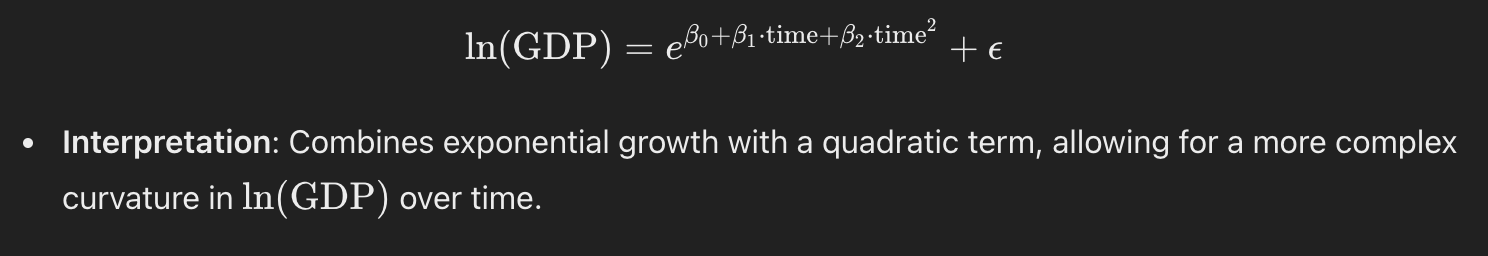

In [7]:
# Exponential Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *ln*

def exponential_quadratic_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 
    x3 = np.empty(T)

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        x3[t] = (t + 1) ** 2
        
    y_exp_quad = np.log(Y)
    
    a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y_exp_quad, x1, x2, x3)
    
    # Initialise predicted values yhat
    yhat_exp_quad = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1) ** 2
        
    return yhat_exp_quad 

# Apply the function to both RGDP and RGDP per capita
yhat_exp_quad_gdp = exponential_quadratic_model(Y_gdp, T_all)
yhat_exp_quad_pc = exponential_quadratic_model(Y_pc, T_all)   

### **3.1.2 GDP Trends: Additive vs Exponential Models**  

The graphs compare trends in **Real GDP** and **Real GDP per capita** using additive and exponential models.  

- **Additive Models:**  
  - The **Linear Additive Model** assumes a constant rate of change in ln(GDP), while the **Quadratic Additive Model** accounts for curvature, capturing shifts in growth trends.  

- **Exponential Models:**  
  - The **Linear Exponential Model** reflects constant percentage growth, while the **Quadratic Exponential Model** introduces nonlinearity, allowing for changes in growth acceleration.  

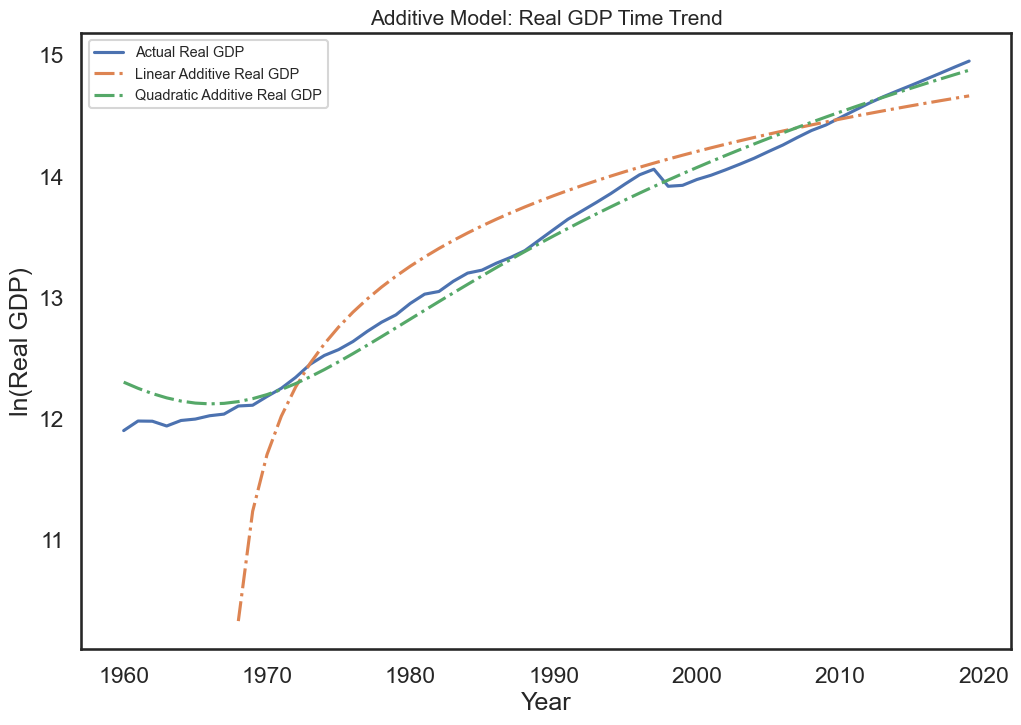

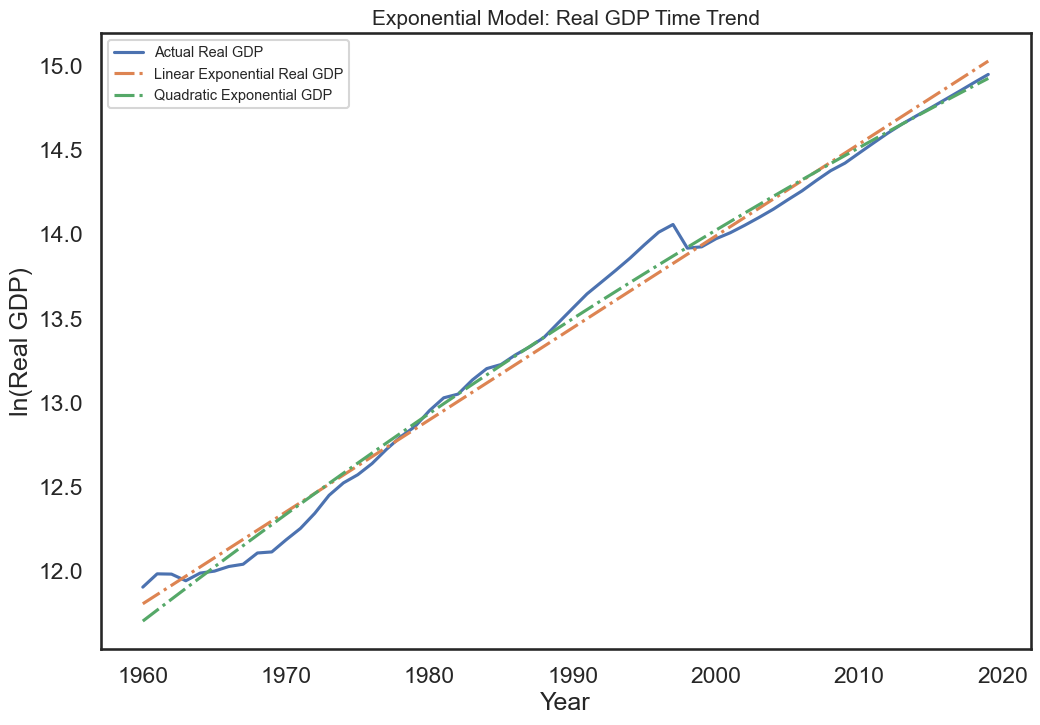

In [8]:
lw = 4  # Line width setting for consistency

# Plot Additive Graph for RGDP
plt.figure(figsize=(12,8))
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia['year'], yhat_add_lin_gdp, label="Linear Additive Real GDP", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_add_quad_gdp, label="Quadratic Additive Real GDP", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("Additive Model: Real GDP Time Trend", fontsize=15)
plt.show()

# Plot Exponential Graph for RGDP
plt.figure(figsize=(12,8))
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia['year'], yhat_exp_lin_gdp, label="Linear Exponential Real GDP", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_exp_quad_gdp, label="Quadratic Exponential GDP", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("Exponential Model: Real GDP Time Trend", fontsize=15)
plt.show()


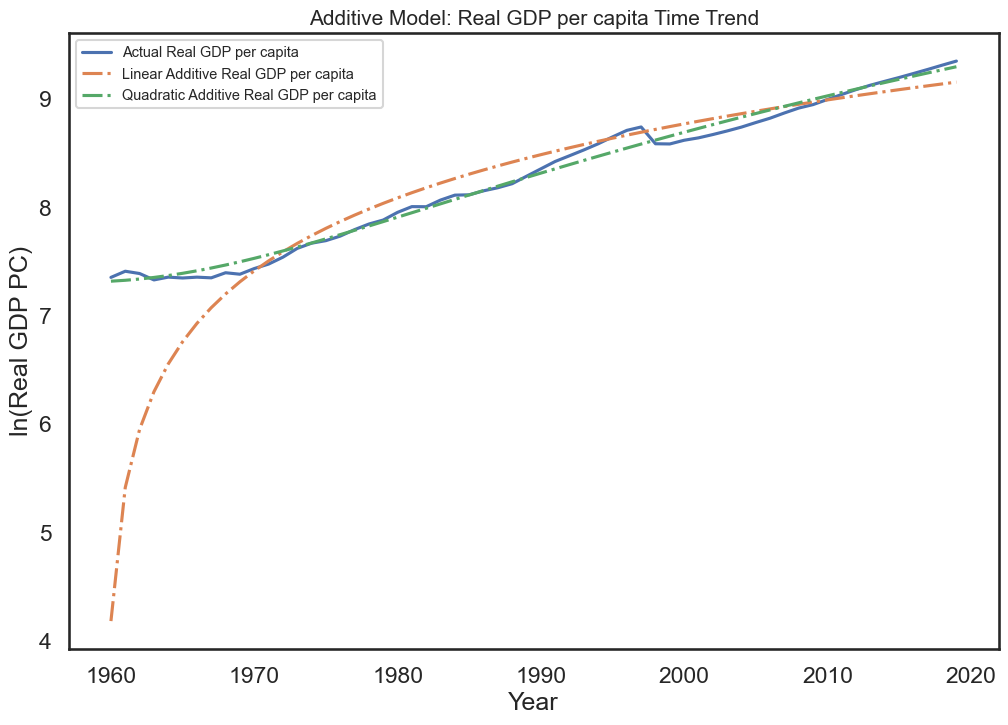

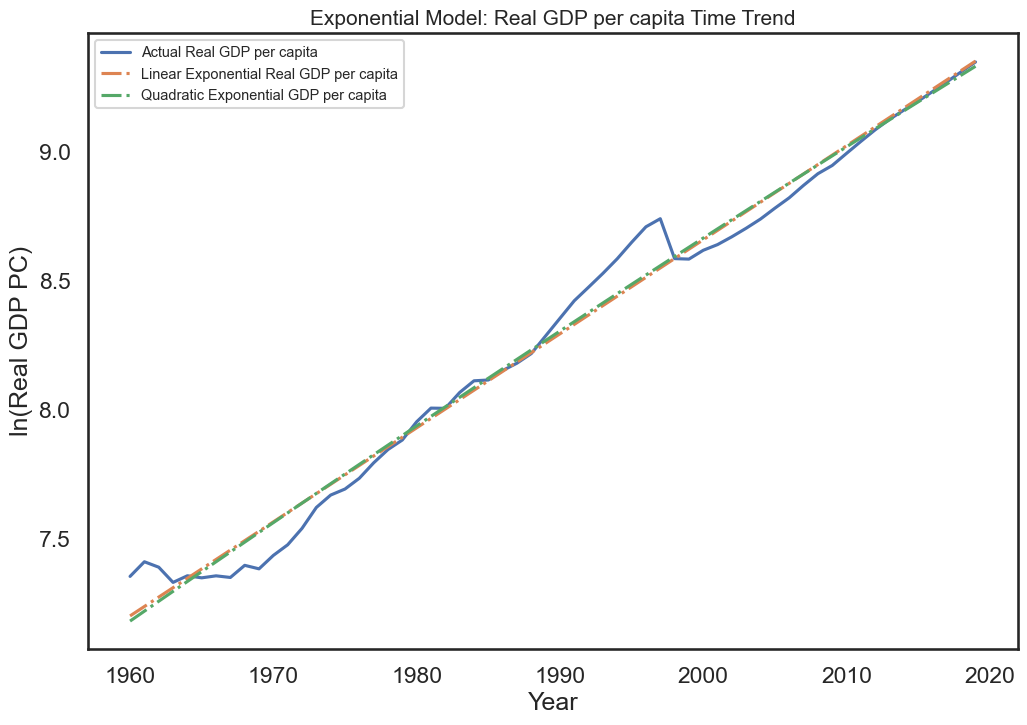

In [9]:
# Plot Additive Graph for RGDP PC
plt.figure(figsize=(12,8))
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")
plt.plot(data_indonesia['year'], yhat_add_lin_pc, label="Linear Additive Real GDP per capita", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_add_quad_pc, label="Quadratic Additive Real GDP per capita", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("ln(Real GDP PC)")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("Additive Model: Real GDP per capita Time Trend", fontsize=15)
plt.show()

# Plot Exponential Graph for RGDP PC
plt.figure(figsize=(12,8))
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")
plt.plot(data_indonesia['year'], yhat_exp_lin_pc, label="Linear Exponential Real GDP per capita", linestyle="dashdot")
plt.plot(data_indonesia['year'], yhat_exp_quad_pc, label="Quadratic Exponential GDP per capita", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("ln(Real GDP PC)")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("Exponential Model: Real GDP per capita Time Trend", fontsize=15)
plt.show()


### **3.1.3 Analyzing GDP Trends Before and After 1998**  

We chose to split the data at **1998** to analyze the impact of the **1997-1998 Asian Financial Crisis (AFC)** on Indonesia’s economy. The crisis caused **a sharp decline in GDP, severe currency depreciation, and structural policy shifts**, fundamentally altering the country's growth trajectory. By examining GDP trends before and after this period, we can assess whether Indonesia's long-term economic growth was significantly affected.  

This section splits Indonesia’s GDP data into two subperiods: **before and after 1998**, allowing us to assess structural changes in economic growth.  

- **Step 1:** The dataset is divided into two periods: **pre-1998** and **post-1998**.  
- **Step 2:** We extract **Real GDP (RGDP)** and **Real GDP per capita (RGDP PC)** for each period.  
- **Step 3:** Sample sizes for each subperiod are computed to verify the data split.  
- **Step 4:** The **Exponential Quadratic Model** is applied separately to each subperiod to estimate fitted values.  
- **Step 5:** The results are visualized to compare GDP trends before and after 1998.  

This approach helps evaluate whether Indonesia’s economic trajectory shifted significantly post-1998, capturing potential **structural breaks** in growth patterns and the economy’s recovery process.


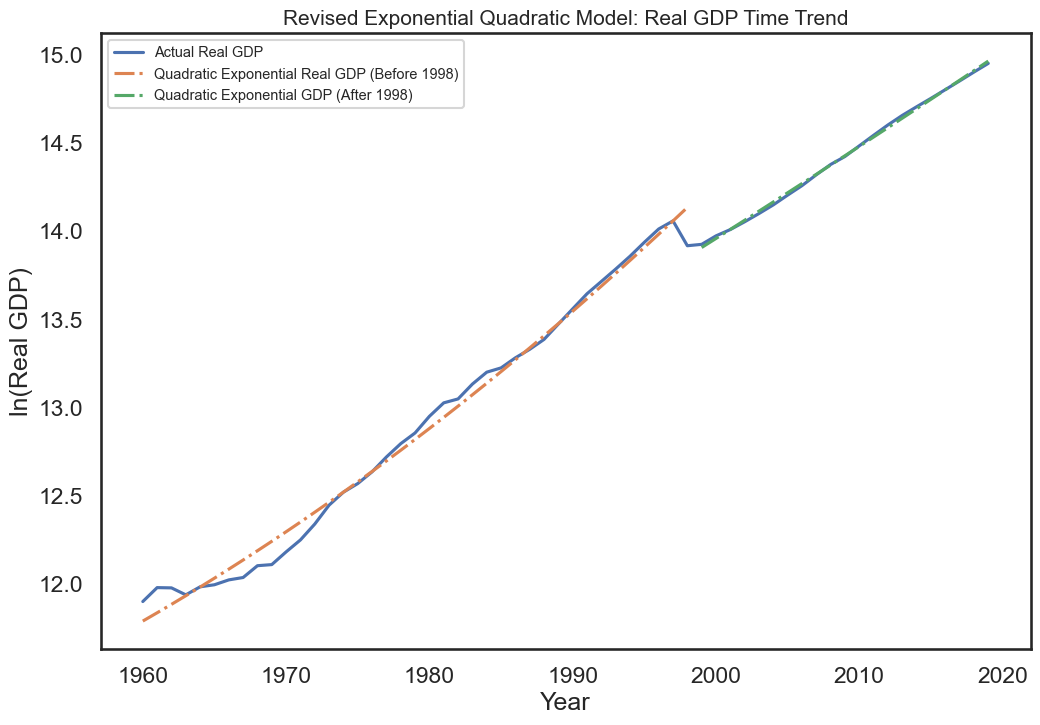

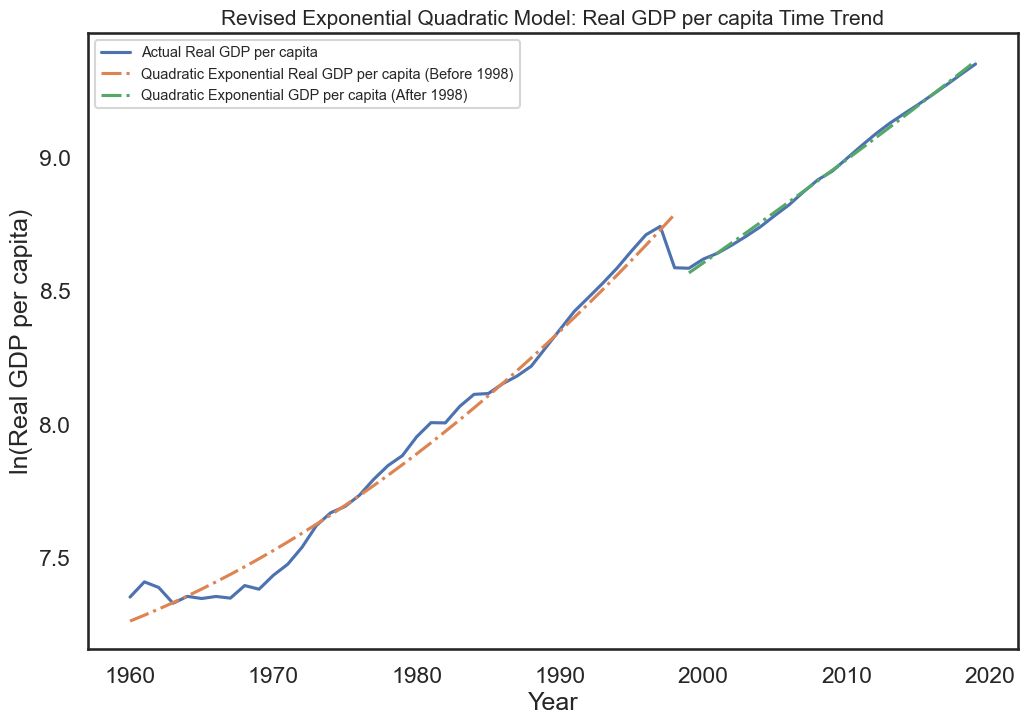

In [10]:
# Split data set into 2 subperiods - before and after 1998 
data_indonesia_before_1998 = data_indonesia[data_indonesia["year"] <= 1998]
data_indonesia_after_1998 = data_indonesia[data_indonesia["year"] > 1998]

# Subset the RGDP and RGDP per capita series
Y_gdp_before_1998 = data_indonesia_before_1998["rgdpna"]
Y_gdp_after_1998 = data_indonesia_after_1998["rgdpna"]
Y_pc_before_1998 = data_indonesia_before_1998["rgdpna_pc"]
Y_pc_after_1998 = data_indonesia_after_1998["rgdpna_pc"]

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T_gdp_before_1998 = len(Y_gdp_before_1998) 
T_gdp_after_1998 = len(Y_gdp_after_1998) 
T_pc_before_1998 = len(Y_pc_before_1998) 
T_pc_after_1998 = len(Y_pc_after_1998) 
T_before_1998 = 1998 - ymin + 1
T_after_1998 = ymax - 1998

# Uncomment the following lines if you need to verify the sample sizes
# print(T_gdp_before_1998, T_gdp_after_1998, T_pc_before_1998, T_pc_after_1998, T_before_1998, T_after_1998)

# Derive fitted values for the 2 subperiods using the exponential quadratic model
yhat_exp_quad_gdp_before_1998 = exponential_quadratic_model(Y_gdp_before_1998, T_before_1998)
yhat_exp_quad_gdp_after_1998 = exponential_quadratic_model(Y_gdp_after_1998, T_after_1998)
yhat_exp_quad_pc_before_1998 = exponential_quadratic_model(Y_pc_before_1998, T_before_1998)
yhat_exp_quad_pc_after_1998 = exponential_quadratic_model(Y_pc_after_1998, T_after_1998)

# Plot Exponential Quadratic Graph for RGDP
plt.figure(figsize=(12, 8)) 
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia_before_1998['year'], yhat_exp_quad_gdp_before_1998, label="Quadratic Exponential Real GDP (Before 1998)", linestyle="dashdot")
plt.plot(data_indonesia_after_1998['year'], yhat_exp_quad_gdp_after_1998, label="Quadratic Exponential GDP (After 1998)", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("Revised Exponential Quadratic Model: Real GDP Time Trend", fontsize=15)

plt.show()  # Ensure the plot renders properly and suppresses text output

# Plot Exponential Quadratic Graph for RGDP PC
plt.figure(figsize=(12, 8)) 
plt.plot(data_indonesia['year'], np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")
plt.plot(data_indonesia_before_1998['year'], yhat_exp_quad_pc_before_1998, label="Quadratic Exponential Real GDP per capita (Before 1998)", linestyle="dashdot")
plt.plot(data_indonesia_after_1998['year'], yhat_exp_quad_pc_after_1998, label="Quadratic Exponential GDP per capita (After 1998)", linestyle="dashdot")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("ln(Real GDP per capita)")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("Revised Exponential Quadratic Model: Real GDP per capita Time Trend", fontsize=15)

plt.show()  


### **3.2 Total Factor Productivity (TFP) Measure**  

#### **Why Include Human Capital (hc)?**  
We included **hc (human capital index)** because **labour quality matters as much as labour quantity**. 

Education and skills make workers more productive, meaning two countries with the same number of workers can have very different output per worker if one has a more skilled workforce.  

By incorporating **hc**, we account for differences in worker skill levels rather than assuming all workers contribute equally to production.  

##### **Importance for Growth Accounting**  
Without **hc**, any differences in productivity would be attributed entirely to **Total Factor Productivity (TFP)**, which includes **technology, policies, and institutions**. 

This could make it harder to identify the real drivers of growth.  

By including **hc**, we can better separate the role of **human capital** from other factors, making our analysis **more precise and meaningful**.

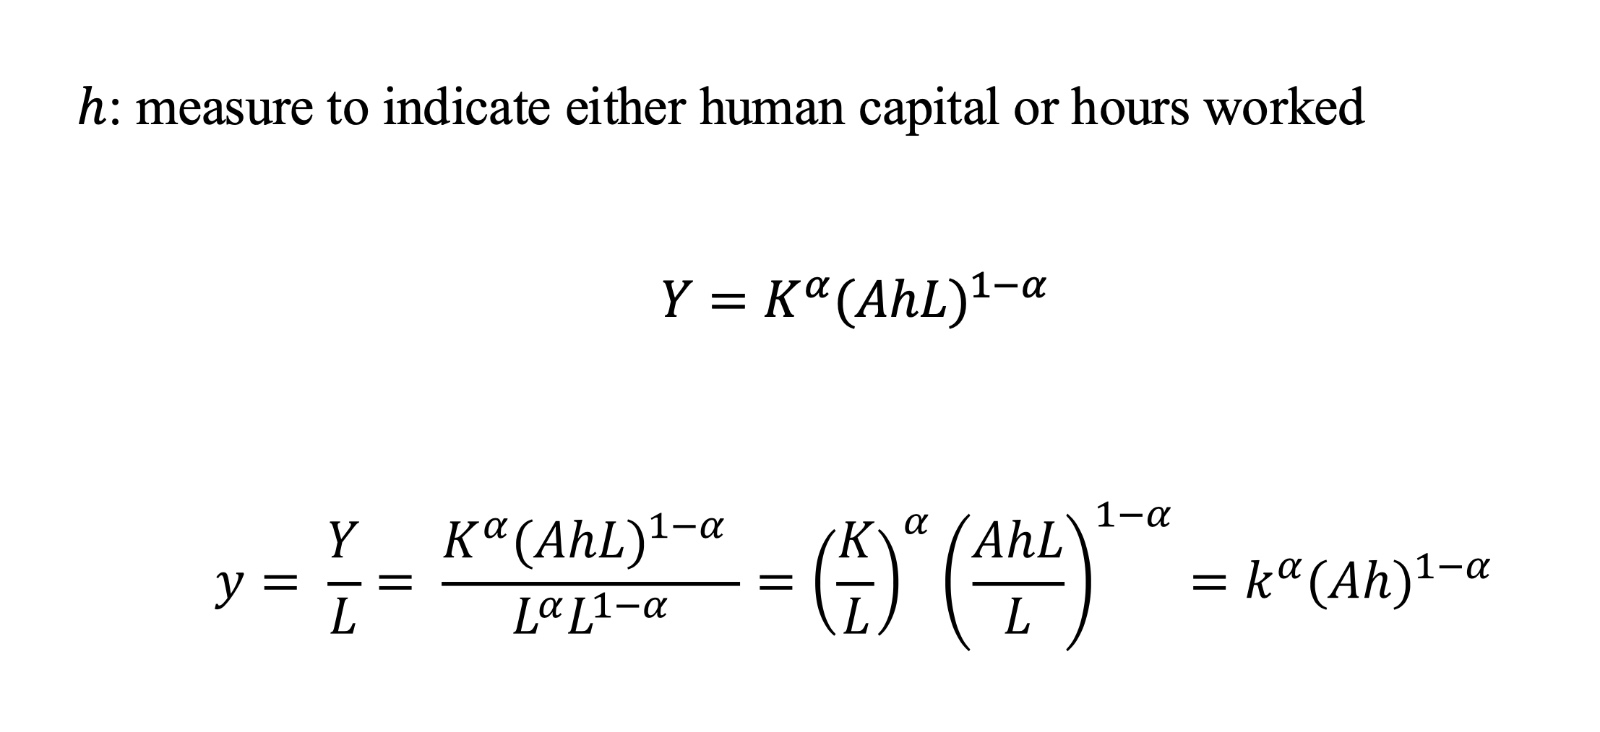
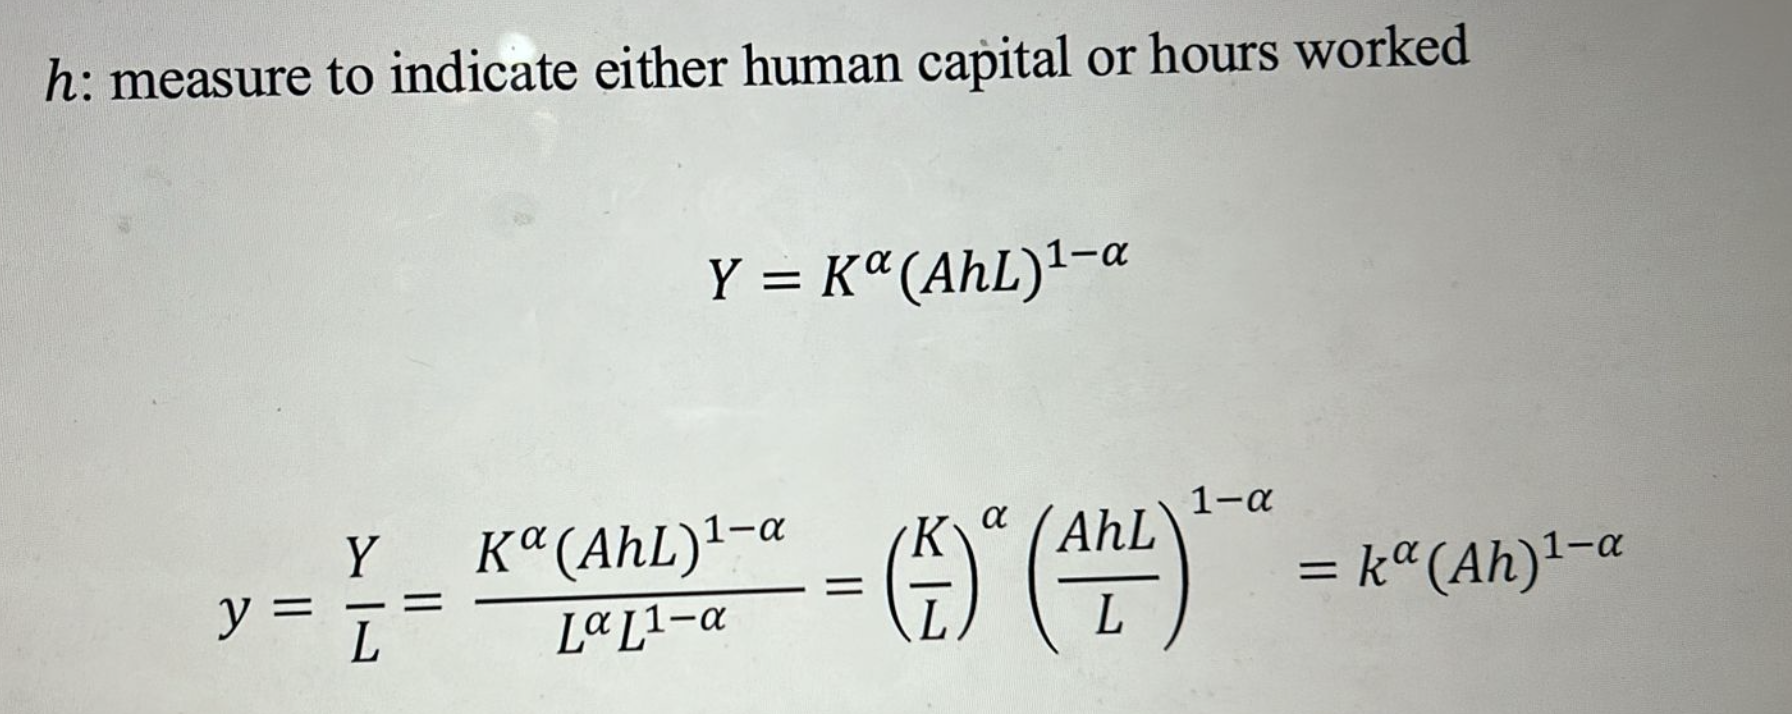

,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35
0,1960,147538.921875,28.498953,762376.7500,1.158581,2584.620672,2210.380296,1845.382708
1,1961,159648.609375,29.060551,765323.1875,1.176857,2768.498671,2384.611743,2007.325066
2,1962,159406.125000,29.569380,764462.1875,1.195421,2674.185813,2303.290030,1938.785826
3,1963,153244.640625,30.088734,756324.5000,1.214278,2463.517674,2116.045162,1775.561034
4,1964,160370.234375,30.618654,751605.5625,1.233432,2537.466753,2190.323887,1848.360916


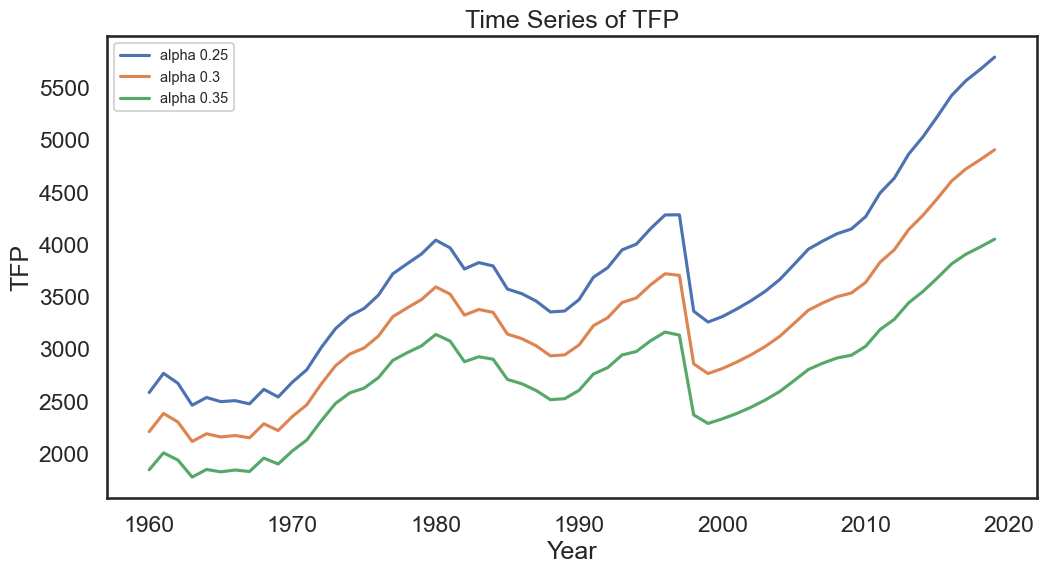

In [11]:
# Calculating TFP

data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

# Extract relevant variables and select Indonesia
data_indonesia_b = data.loc[data["country"] == "Indonesia", ["year", "rgdpna", "emp", "rnna", "hc"]]

# Drop rows with missing values
data_indonesia_b.dropna(subset=["rgdpna", "emp", "rnna", "hc"], inplace=True)

# Define alpha values for robustness check
alpha_values = [0.25, 0.3, 0.35]

# Calculate TFP for each alpha
tfp_results = {}

for alpha in alpha_values:
    tfp = (1 / (data_indonesia_b["emp"] * data_indonesia_b["hc"])) * \
          (data_indonesia_b["rgdpna"] / (data_indonesia_b["rnna"]) ** alpha) ** (1 / (1 - alpha))
    tfp_results[f"TFP_alpha_{alpha}"] = tfp

# Convert results to DataFrame
tfp_df = pd.DataFrame(tfp_results)
tfp_df["year"] = data_indonesia_b["year"]

# Merge with original DataFrame
data_indonesia_b = data_indonesia_b.merge(tfp_df, on="year")

# Display DataFrame
display(data_indonesia_b.head())

# Plot Time Series
plt.figure(figsize=(12, 6)) 
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.25"], label="alpha 0.25")
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.3"], label="alpha 0.3")
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.35"], label="alpha 0.35")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("TFP")
plt.legend(fontsize='xx-small', loc='upper left')
plt.title("Time Series of TFP")

# Ensure only the plot is displayed, suppressing text output
plt.show()


### **3.3 Growth Accounting**

Calculated average growth rates for GDP, capital, labour (adjusted by human capital), and TFP over six decades. 

Proportional contributions of each input were analysed, and a time series plot was created to highlight their impact on long-term GDP growth.


In [12]:
# Growth Accounting - Data Preparation
# Ensure the year column is of integer type
data_indonesia_b["year"] = data_indonesia_b["year"].astype(int)

# Display the updated DataFrame
display(data_indonesia_b.head())


,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35
0,1960,147538.921875,28.498953,762376.7500,1.158581,2584.620672,2210.380296,1845.382708
1,1961,159648.609375,29.060551,765323.1875,1.176857,2768.498671,2384.611743,2007.325066
2,1962,159406.125000,29.569380,764462.1875,1.195421,2674.185813,2303.290030,1938.785826
3,1963,153244.640625,30.088734,756324.5000,1.214278,2463.517674,2116.045162,1775.561034
4,1964,160370.234375,30.618654,751605.5625,1.233432,2537.466753,2190.323887,1848.360916


In [13]:
# Initialise dataframe with NaNs for storing average growth rates
avg_growth_rates = pd.DataFrame(
    data=np.full((6, 5), np.nan),
    columns=['Y growth', 'K growth', 'L growth', 'h growth', 'A growth']
)
avg_growth_rates['year'] = ["1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2019"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Set alpha = 0.3 
alpha = 0.3

# Fill with average growth rates from data_indonesia_b
cols = ['rgdpna', 'rnna', 'emp', 'hc', 'TFP_alpha_0.3']

# Ensure the years exist in the DataFrame
years = [1960, 1970, 1980, 1990, 2000, 2010, 2019]
for start, end in zip(years[:-1], years[1:]):
    if start in data_indonesia_b["year"].values and end in data_indonesia_b["year"].values:
        avg_growth_rates.loc[f"{start}-{end}"] = np.log(
            data_indonesia_b.loc[data_indonesia_b["year"] == end, cols].values /
            data_indonesia_b.loc[data_indonesia_b["year"] == start, cols].values
        ).flatten()



In [14]:
# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['h contribution'] = (1 - alpha) * (df_contribs_long['h growth'] / df_contribs_long['Y growth'])
df_contribs_long['L contribution'] = (1 - alpha) * (df_contribs_long['L growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = (1 - alpha) * (df_contribs_long['A growth'] / df_contribs_long['Y growth'])

# Create dataframe of the contributions
df_contribs = df_contribs_long[['Y growth', 'K contribution', 'h contribution', 'L contribution', 'A contribution']]

# Display dataframe of the contributions
display(df_contribs.head())


,Y growth,K contribution,h contribution,L contribution,A contribution
year,,,,,
1960-1970,0.281279,0.010385,0.389497,0.440837,0.159280
1970-1980,0.767951,0.245765,0.103752,0.265194,0.385288
1980-1990,0.608867,0.383940,0.255054,0.554069,-0.193064
1990-2000,0.413341,0.521737,0.241396,0.367473,-0.130606
2000-2010,0.510038,0.280599,0.137946,0.228779,0.352676


In [15]:
# Create dataframe of the growth rates
df_contribs_growth_rates = df_contribs_long[['Y growth', 'K growth', 'h growth', 'L growth', 'A growth']]
display(df_contribs_growth_rates.head())

# Calculate the sum of A growth, h growth, and L growth
df_contribs_growth_rates_sum = df_contribs_growth_rates.copy()
df_contribs_growth_rates_sum.loc[:, 'Sum of A, h, L growth'] = (
    df_contribs_growth_rates_sum['A growth'] +
    df_contribs_growth_rates_sum['h growth'] +
    df_contribs_growth_rates_sum['L growth']
)

# Calculate the difference between gA+gL+gh and gY 
df_contribs_growth_rates_sum.loc[:, 'Difference'] = (
    df_contribs_growth_rates_sum['Sum of A, h, L growth'] - df_contribs_growth_rates_sum['Y growth']
)

# Create a new dataframe with sub-periods as rows, and columns for gY and the sum of A, h, L growth
df_table = df_contribs_growth_rates_sum[['Y growth', 'Sum of A, h, L growth', 'Difference']]

# Display the resulting dataframe
display(df_table.head())


,Y growth,K growth,h growth,L growth,A growth
year,,,,,
1960-1970,0.281279,0.009737,0.156511,0.177141,0.064003
1970-1980,0.767951,0.629118,0.113824,0.290938,0.422690
1980-1990,0.608867,0.779229,0.221849,0.481935,-0.167929
1990-2000,0.413341,0.718852,0.142541,0.216988,-0.077121
2000-2010,0.510038,0.477054,0.100511,0.166694,0.256969


,Y growth,"Sum of A, h, L growth",Difference
year,,,
1960-1970,0.281279,0.397654,0.116375
1970-1980,0.767951,0.827451,0.059500
1980-1990,0.608867,0.535855,-0.073012
1990-2000,0.413341,0.282408,-0.130933
2000-2010,0.510038,0.524174,0.014136


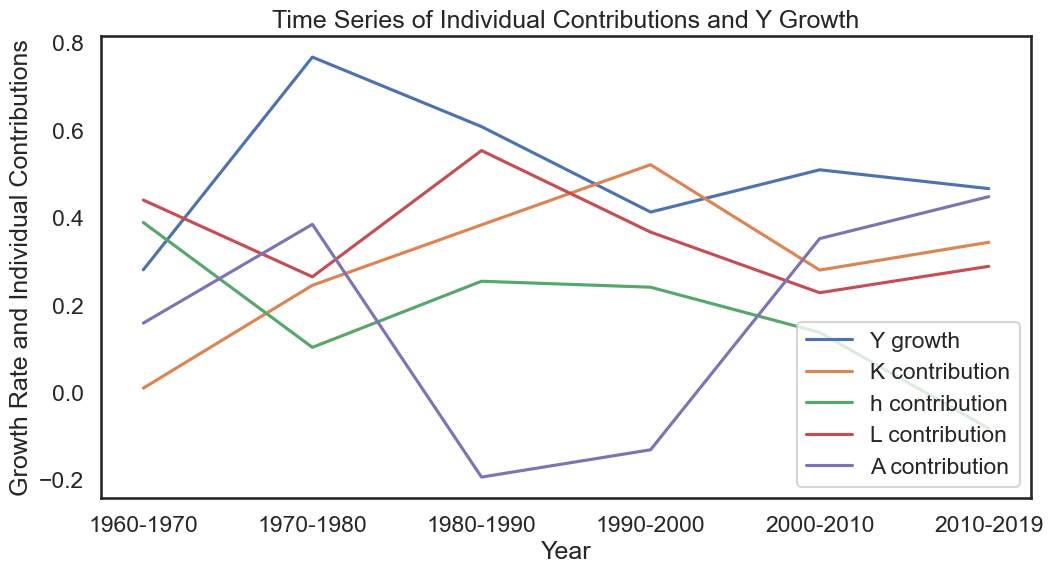

In [16]:
# Plotting the time series of contributions
plt.figure(figsize=(12, 6))
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')
plt.plot(df_contribs_long.index, df_contribs_long['K contribution'], label='K contribution')
plt.plot(df_contribs_long.index, df_contribs_long['h contribution'], label='h contribution')
plt.plot(df_contribs_long.index, df_contribs_long['L contribution'], label='L contribution')
plt.plot(df_contribs_long.index, df_contribs_long['A contribution'], label='A contribution')

# Adding titles and labels
plt.title('Time Series of Individual Contributions and Y Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate and Individual Contributions')
plt.legend()

# Display the plot
plt.show()


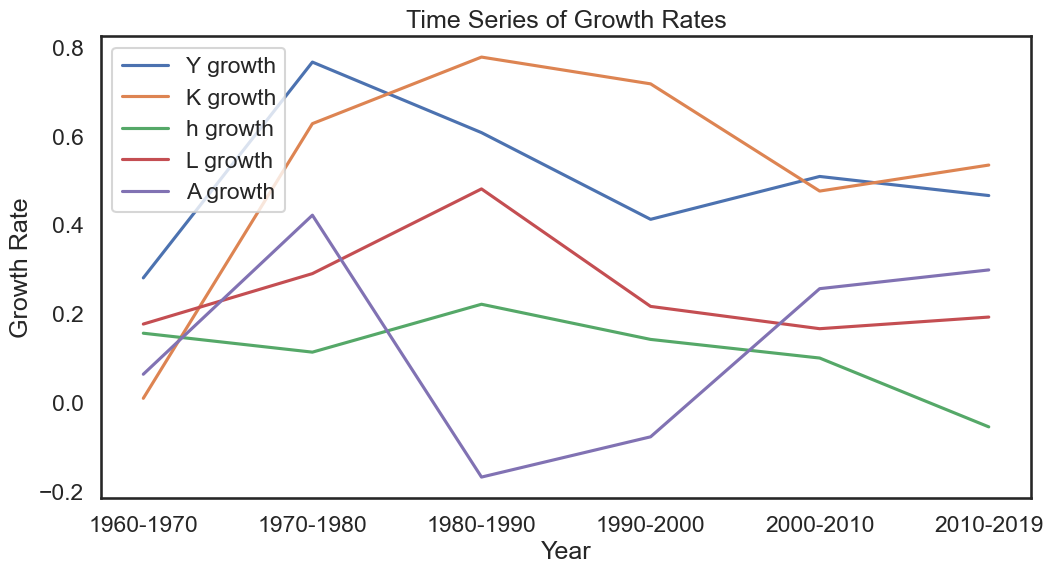

In [17]:
# Plotting the time series of growth rates
plt.figure(figsize=(12, 6))
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')
plt.plot(df_contribs_long.index, df_contribs_long['K growth'], label='K growth')
plt.plot(df_contribs_long.index, df_contribs_long['h growth'], label='h growth')
plt.plot(df_contribs_long.index, df_contribs_long['L growth'], label='L growth')
plt.plot(df_contribs_long.index, df_contribs_long['A growth'], label='A growth')

# Adding titles and labels
plt.title('Time Series of Growth Rates')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()

# Display the plot
plt.show()


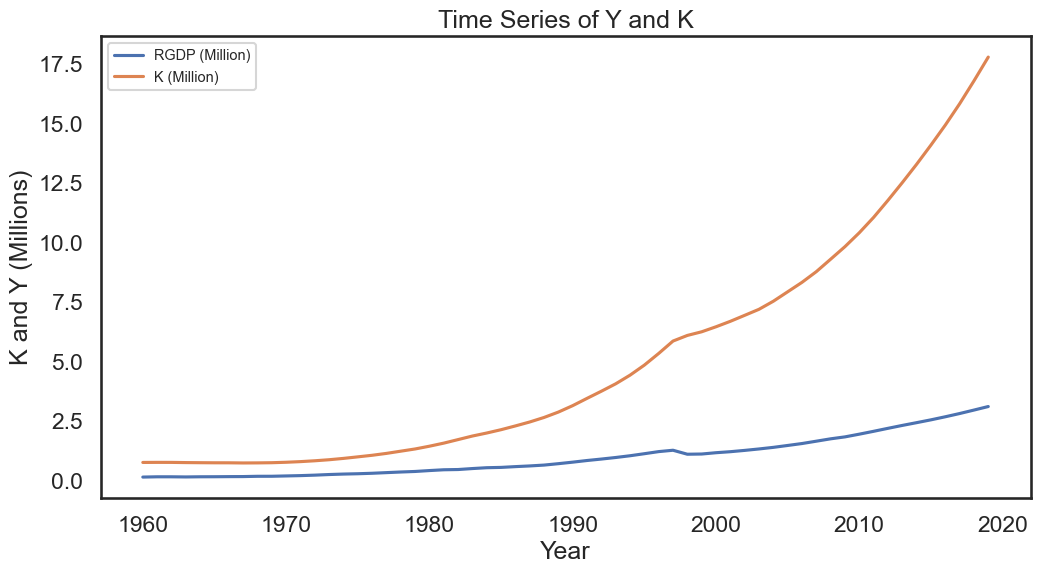

In [18]:
# Scale Y and K to millions
data_indonesia_b["rgdpna_million"] = data_indonesia_b["rgdpna"] / 1e6
data_indonesia_b["rnna_million"] = data_indonesia_b["rnna"] / 1e6

# Plotting the time series of Y and K in millions
plt.figure(figsize=(12, 6))
plt.plot(data_indonesia_b['year'], data_indonesia_b["rgdpna_million"], label="RGDP (Million)")
plt.plot(data_indonesia_b['year'], data_indonesia_b["rnna_million"], label="K (Million)")

# Labels
plt.xlabel("Year")
plt.ylabel("K and Y (Millions)")
plt.legend(fontsize='xx-small', loc='upper left')

# Title
plt.title("Time Series of Y and K")

# Show plot
plt.show()



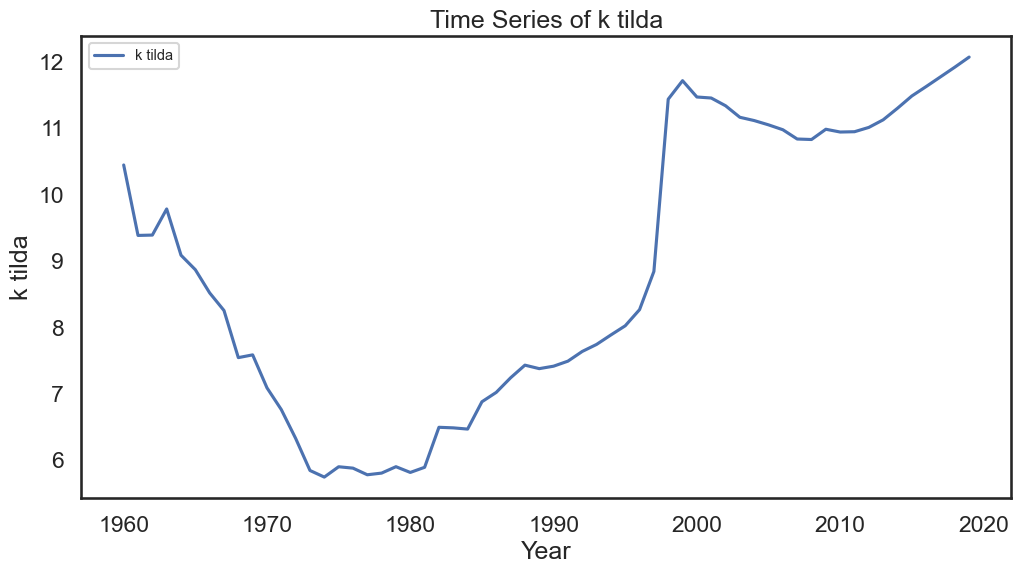

In [19]:
# Create k tilda variable and add it to the DataFrame
data_indonesia_b["k_tilda"] = data_indonesia_b["rnna"] / (data_indonesia_b["TFP_alpha_0.3"] * data_indonesia_b["hc"] * data_indonesia_b["emp"]) 

# Plotting the time series of k tilda 
plt.figure(figsize=(12, 6))
plt.plot(data_indonesia_b['year'], data_indonesia_b["k_tilda"], label="k tilda")

# Labels
plt.xlabel("Year")
plt.ylabel("k tilda")
plt.legend(fontsize='xx-small', loc='upper left')

# Title
plt.title("Time Series of k tilda")

# Show plot
plt.show()


### **3.3.2 Stacked Contributions to Output Growth Over Time**  
This chart shows the contributions of total factor productivity, labour, human capital, and capital to output growth across different time periods.

The x-axis is centred at 0.5 for clearer comparison, and the stacked bars highlight the relative impact of each factor over time.

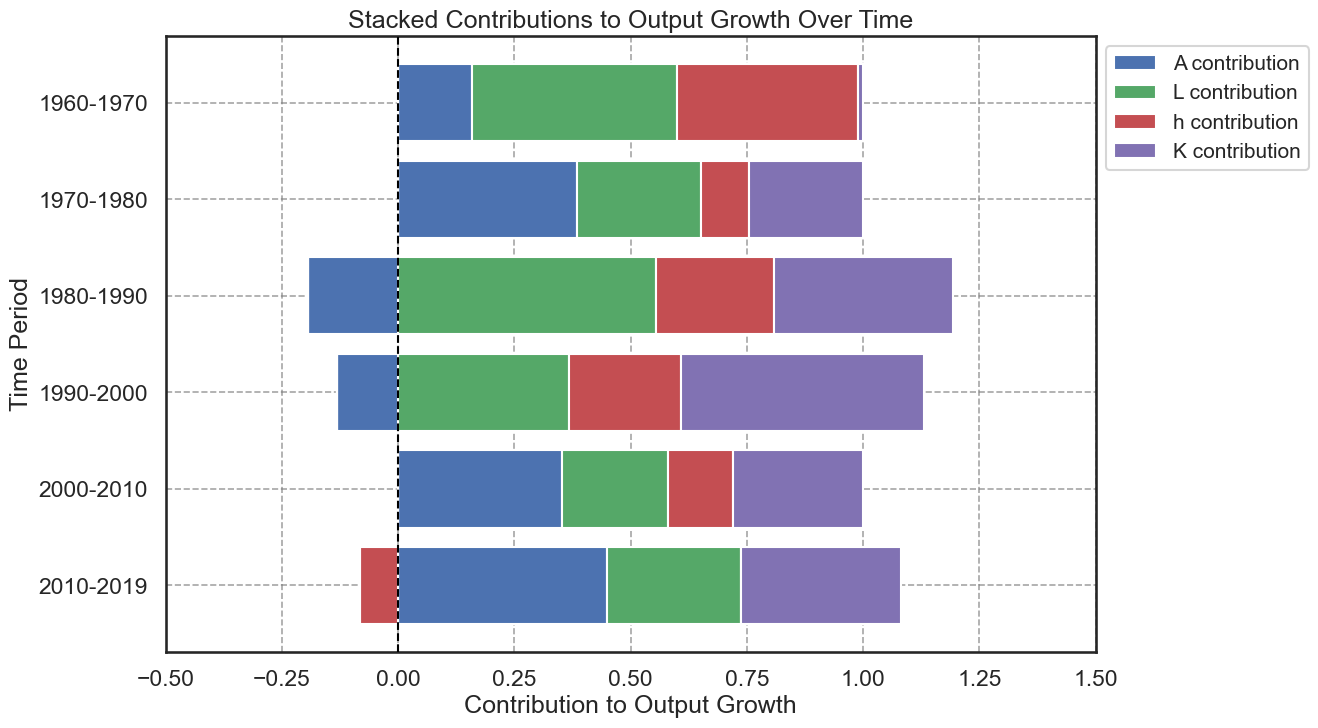

In [20]:
# Reverse the order of time periods for better readability
categories = df_contribs_long.index[::-1]  

# Extract contribution values
k_contribution = df_contribs_long['K contribution'][::-1].values
h_contribution = df_contribs_long['h contribution'][::-1].values
l_contribution = df_contribs_long['L contribution'][::-1].values
a_contribution = df_contribs_long['A contribution'][::-1].values

# Separate positive and negative contributions
k_pos = np.where(k_contribution > 0, k_contribution, 0)
h_pos = np.where(h_contribution > 0, h_contribution, 0)
l_pos = np.where(l_contribution > 0, l_contribution, 0)
a_pos = np.where(a_contribution > 0, a_contribution, 0)

k_neg = np.where(k_contribution < 0, k_contribution, 0)
h_neg = np.where(h_contribution < 0, h_contribution, 0)
l_neg = np.where(l_contribution < 0, l_contribution, 0)
a_neg = np.where(a_contribution < 0, a_contribution, 0)

# Define professional color palette
colors = {
    "A contribution": "#4C72B0",  # Deep Blue
    "L contribution": "#55A868",  # Muted Green
    "h contribution": "#C44E52",  # Muted Red
    "K contribution": "#8172B3",  # Deep Purple
}

# Set figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Stack positive contributions
ax.barh(categories, a_pos, label="A contribution", color=colors["A contribution"], zorder=3)
ax.barh(categories, l_pos, left=a_pos, label="L contribution", color=colors["L contribution"], zorder=3)
ax.barh(categories, h_pos, left=a_pos + l_pos, label="h contribution", color=colors["h contribution"], zorder=3)
ax.barh(categories, k_pos, left=a_pos + l_pos + h_pos, label="K contribution", color=colors["K contribution"], zorder=3)

# Stack negative contributions separately (left side)
ax.barh(categories, a_neg, color=colors["A contribution"], zorder=3)
ax.barh(categories, l_neg, left=a_neg, color=colors["L contribution"], zorder=3)
ax.barh(categories, h_neg, left=a_neg + l_neg, color=colors["h contribution"], zorder=3)
ax.barh(categories, k_neg, left=a_neg + l_neg + h_neg, color=colors["K contribution"], zorder=3)

# Set x-axis limits from -1 to 1
ax.set_xlim(-0.5, 1.5)

# Add a bold dashed reference line at 0
ax.axvline(x=0, color='black', linestyle="dashed", linewidth=1.5, zorder=4)

# Add equally bold dashed grid lines
ax.grid(True, which='both', axis='both', color='grey', linestyle='--', linewidth=1.2, alpha=0.7, zorder=2)

# Labels and title
ax.set_xlabel("Contribution to Output Growth")
ax.set_ylabel("Time Period")
ax.set_title("Stacked Contributions to Output Growth Over Time")

# Move legend outside the plot
ax.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


### **3.4 Labour Productivity**

Labour productivity, measured as GDP per worker, was calculated to track economic efficiency. 

A time series plot compares labour productivity with Total Factor Productivity (TFP) to show their trends over time in Indonesia's growth.


#### **3.4.1 Time Series of TFP and Labour Productivity**

This section examines the trends in **Total Factor Productivity (TFP)** and **labour productivity** over time, highlighting their contributions to economic growth and structural changes in Indonesia’s economy.

,year,labour_productivity
0,1960,5176.994487
1,1961,5493.653960
2,1962,5390.918783
3,1963,5093.090400
4,1964,5237.664368


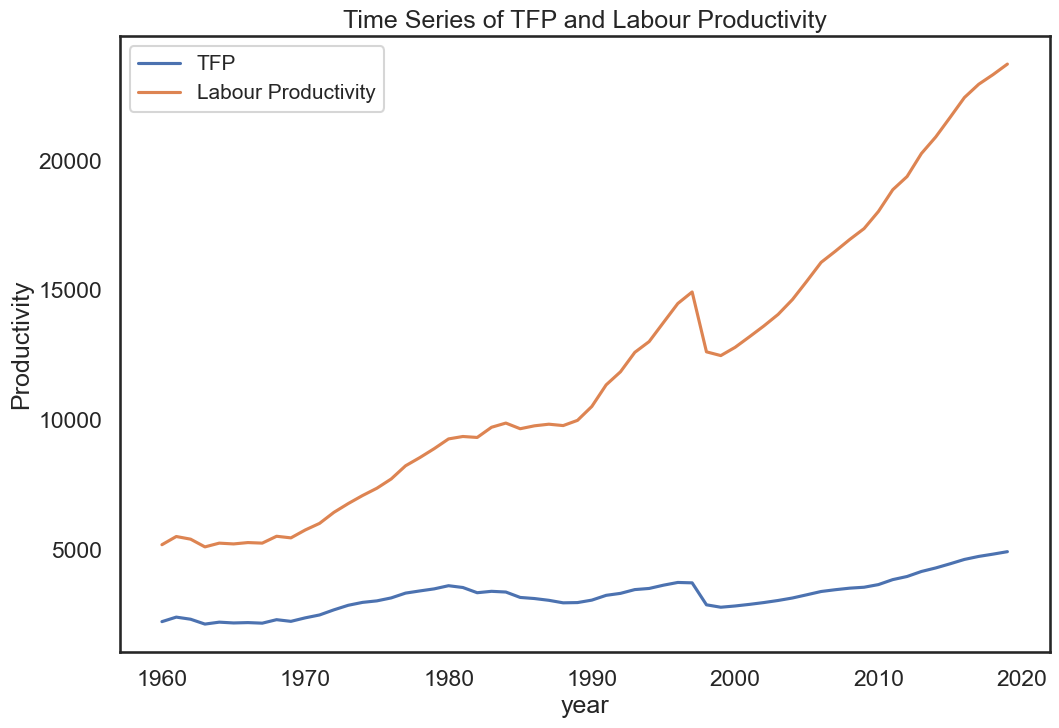

In [21]:
# Labour Productivity 
# Calculate labor productivity (GDP per worker)
data_indonesia_b["labour_productivity"] = data_indonesia_b["rgdpna"] / data_indonesia_b["emp"]

# Display the updated DataFrame
display(data_indonesia_b[["year", "labour_productivity"]].head())

# Plot Time Series with larger figure size
plt.figure(figsize=(12, 8))  # Adjust the figsize to make the graph bigger
plt.plot(data_indonesia_b['year'], data_indonesia_b["TFP_alpha_0.3"], label="TFP")
plt.plot(data_indonesia_b['year'], data_indonesia_b["labour_productivity"], label="Labour Productivity")

# Labels
plt.xlabel("year")
plt.ylabel("Productivity")
plt.legend(fontsize='small', loc='upper left')  # Slightly larger font size for better readability

# Title
plt.title("Time Series of TFP and Labour Productivity")

# Explicitly render the plot
plt.show()


#### **3.4.2 Normalised Time Series of TFP and Labour Productivity**


To ensure **TFP** and **labour productivity** are on a comparable scale, we normalise them by setting **1960 as the base year** and dividing all values by their respective 1960 values. 

We then take the **log** of these normalised values, allowing the **slope of the curves to represent growth rates** over time.



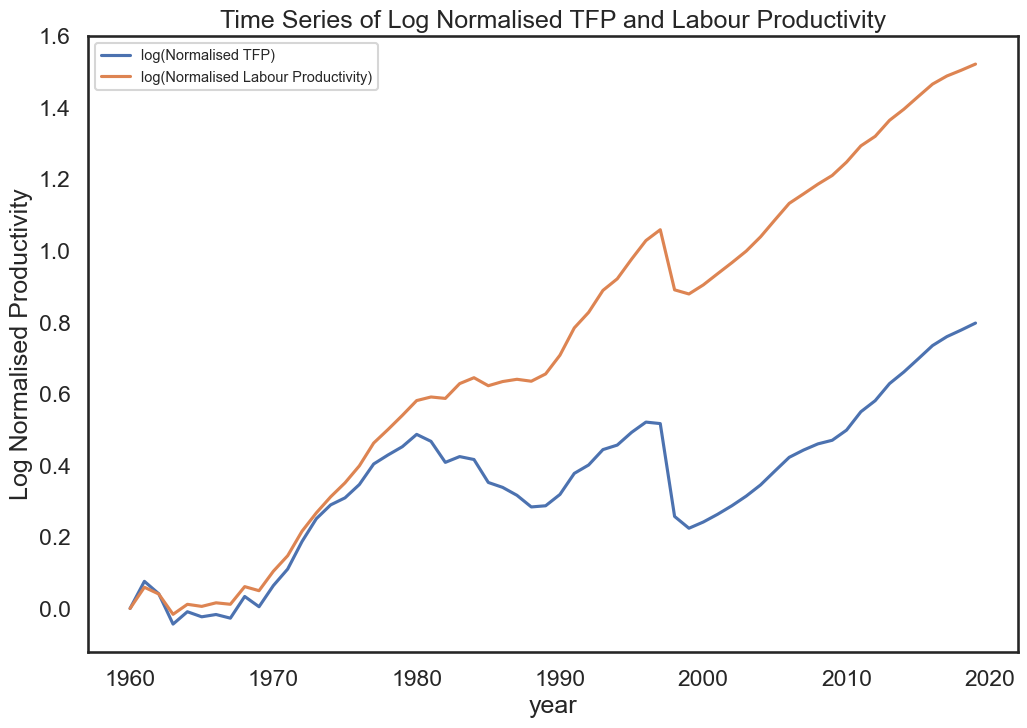

In [22]:
# Normalize labour productivity and TFP by dividing by the first year value
data_indonesia_b["labour_productivity_normalized"] = data_indonesia_b["labour_productivity"] / data_indonesia_b["labour_productivity"].iloc[0]
data_indonesia_b["TFP_normalized"] = data_indonesia_b["TFP_alpha_0.3"] / data_indonesia_b["TFP_alpha_0.3"].iloc[0]

# Take the natural logarithm of the normalized values
data_indonesia_b["ln_labour_productivity_normalized"] = np.log(data_indonesia_b["labour_productivity_normalized"])
data_indonesia_b["ln_TFP_normalized"] = np.log(data_indonesia_b["TFP_normalized"])

# Plot Time Series
plt.figure(figsize=(12, 8)) 
plt.plot(data_indonesia_b['year'], data_indonesia_b["ln_TFP_normalized"], label="TFP")
plt.plot(data_indonesia_b['year'], data_indonesia_b["ln_labour_productivity_normalized"], label="Labour Productivity")
# Labels
plt.xlabel("year")
plt.ylabel("Log Normalised Productivity")
plt.legend(['log(Normalised TFP)', 'log(Normalised Labour Productivity)'], fontsize='xx-small', loc='upper left')

# Title
plt.title("Time Series of Log Normalised TFP and Labour Productivity")
plt.show()